## Spectral Clustering

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import itertools
from scipy.stats import multivariate_normal

%matplotlib inline

In [2]:
'''
References:
1. Ng, Jordan, Weiss. On Spectral Clustering: Analysis and an algorithm. (2001)
2. Zelnik-Manor, Perona. Self-Tuning Spectral Clustering. (2004)

A part of code is taken from hw3.
'''

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
class spectral_clustering_mod:
    '''
    X - numpy.ndarray - The dataset. Size is samples x features.
    k - int - The number of clusters.
    mode - string - A value of ['variance', 'selftune'].
                  - 'variance' - Ng's method
                  - 'selftune' - Zelnik-Manor's method
    sigsq - double - only used when mode == 'variance'.
    ik - int - only used when mode == 'selftune'.
    '''
    def __init__(self, k=3, mode='variance', sigsq = 0.9, ik = 7):
        self.k = int(k)
        self.mode = mode
        self.sigsq = sigsq
        self.ik = int(ik)
    
    def fit(self, X):
        self.X = X
        self.dist = squareform(pdist(X, 'sqeuclidean'))
        # avoid division by zero
        self.dist += np.spacing(1)
        
        switch = {
            'variance': self.affinity_variance,
            'selftune': self.affinity_selftune
        }
        
        switch.get(self.mode)()
        
        return self.main()
    
    def affinity_variance(self):
        A_raw = np.exp(-self.dist / (2 * self.sigsq))
        self.A = A_raw - np.diag(np.diag(A_raw))
    
    def affinity_selftune(self):
        distsqrt = np.sqrt(self.dist)
        sigmaK = np.zeros(distsqrt.shape[0])
        for i in range(distsqrt.shape[0]):
            row = distsqrt[i, :]
            sigmaK[i] = np.sort(row)[self.ik]
        self.sigmaM = np.matrix(sigmaK).T.dot(np.matrix(sigmaK))
        A_raw = np.exp(np.divide(-self.dist, self.sigmaM))
        self.A = np.array(A_raw - np.diag(np.diag(A_raw)))
    
    def main(self):
        D = np.diag(np.sum(self.A.T, axis=0))
        self.L = np.linalg.inv(np.sqrt(D)).dot(self.A).dot(np.linalg.inv(np.sqrt(D)))
        
        eigval, eigvec = np.linalg.eig(self.L)
        self.V = self.eigsort(eigvec, eigval, self.k)
        
        self.Y = normalize(self.V, norm='l2', axis=1)
        
        kmeans = KMeans(n_clusters=self.k).fit(self.Y)
        return kmeans.labels_
    
    def eigsort(self, V, eigvals, k):
        # Sort the eigenvalues from largest to smallest. Store the sorted
        # eigenvalues in the column vector lambd.
        lohival = np.sort(eigvals)
        lohiindex = np.argsort(eigvals)
        lambd = np.flip(lohival)
        index = np.flip(lohiindex)
        Dsort = np.diag(lambd)

        # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
        # eigenvectors as columns of the matrix vsort.
        M = np.size(lambd)
        Vsort = np.zeros((M, k))
        for i in range(k):
            Vsort[:,i] = V[:,index[i]]
        return Vsort

In [4]:
data = pd.read_csv('abalone.data', header=None)
dataLabels = ['Sex', 'Length', 'Diam', 'Height','Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell', 'Rings']
data.columns = dataLabels

data = data.to_numpy()

labels = data[:, 0]
data = data[:, 1:]
data.shape

(4177, 8)

In [5]:
# Prepare the scaling of data
scaler = StandardScaler()
data_t = scaler.fit_transform(data)

In [6]:
def accuracy_calc(labels, predict, full=False):
    max_acc = 0
    max_mfi = [0, 0, 0]
    max_iter = None
    num = predict.shape[0]
    for i in itertools.permutations(range(3)):
        labels_t = labels.copy()
        labels_t[labels_t == 'M'] = i[0]
        labels_t[labels_t == 'F'] = i[1]
        labels_t[labels_t == 'I'] = i[2]
        total = [0, 0, 0]
        correct = [0, 0, 0]
        for j in range(num):
            total[labels_t[j]] += 1
            if predict[j] == labels_t[j]:
                correct[predict[j]] += 1
        acc = float(sum(correct)) / num
        if acc > max_acc:
            max_acc = acc
            max_mfi[0] = float(correct[i[0]]) / total[i[0]]
            max_mfi[1] = float(correct[i[1]]) / total[i[1]]
            max_mfi[2] = float(correct[i[2]]) / total[i[2]]
            max_iter = i
    predict_s = []
    for i in range(num):
        s_map = {max_iter[0]: 'M', max_iter[1]: 'F', max_iter[2]: 'I'}
        predict_s.append(s_map[predict[i]])
    if full:
        return max_acc, max_mfi, predict_s
    else:
        return max_acc

In [7]:
# Select best variance
v_best_acc = 0
v_best_mfi = None
v_best_predict = None
v_best_predict_s = None
v_best_var = 0
v_acc_list = []

for i in np.linspace(0.3, 2.3, 11):
    predict = spectral_clustering_mod(3, 'variance', i).fit(data_t)
    acc, mfi, predict_s = accuracy_calc(labels, predict, True)
    v_acc_list.append(acc)
    print(i, acc)
    if acc > v_best_acc:
        v_best_acc = acc
        v_best_mfi = mfi
        v_best_predict = predict
        v_best_predict_s = predict_s
        v_best_var = i

print()
print('Best sigsq:', v_best_var)
print('Total Accuracy:', v_best_acc)
print('Male Accuracy:', v_best_mfi[0])
print('Female Accuracy:', v_best_mfi[1])
print('Infant Accuracy:', v_best_mfi[2])

0.3 0.4888676083313383
0.5 0.4955709839597797
0.7 0.4991620780464448
0.8999999999999999 0.5013167344984438
1.0999999999999999 0.5015561407708882
1.2999999999999998 0.5020349533157769
1.5 0.5034713909504429
1.7 0.505626047402442
1.9 0.5053866411299976
2.0999999999999996 0.5044290160402203
2.3 0.5039502034953316

Best sigsq: 1.7
Total Accuracy: 0.505626047402442
Male Accuracy: 0.43324607329842935
Female Accuracy: 0.5080336648814078
Infant Accuracy: 0.5856929955290611


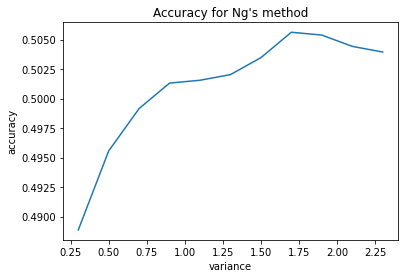

In [8]:
plt.title('Accuracy for Ng\'s method')
plt.xlabel('variance')
plt.ylabel('accuracy')
plt.plot(np.linspace(0.3, 2.3, 11), v_acc_list)
plt.show()

In [9]:
def plot_result(predict_s):
    x = itertools.combinations([0,1,2,3,4,5,6,7], 2)
    possible_2D_combos = []

    for subset in x:
        possible_2D_combos.append(subset)

    InitColorMat = np.eye(3)
    colorVec = np.zeros((len(predict_s), 3))
    predict_s_arr = np.array(predict_s)
    colorVec[predict_s_arr == 'M'] = InitColorMat[0]
    colorVec[predict_s_arr == 'F'] = InitColorMat[1]
    colorVec[predict_s_arr == 'I'] = InitColorMat[2]

    for combo in possible_2D_combos:
        plt.figure()
        plt.title("Abalone " + dataLabels[combo[0] + 1]+ " vs "+ dataLabels[combo[1] + 1])
        plt.scatter(data[:, combo[0]], data[:, combo[1]], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
        plt.show()

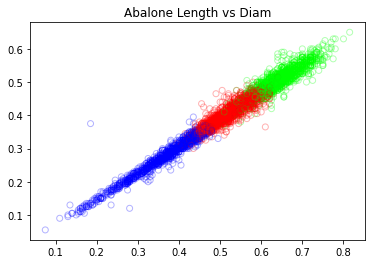

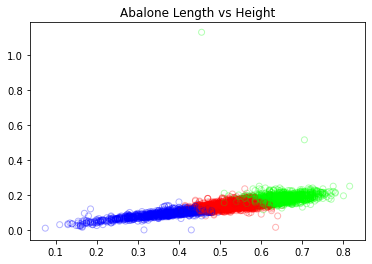

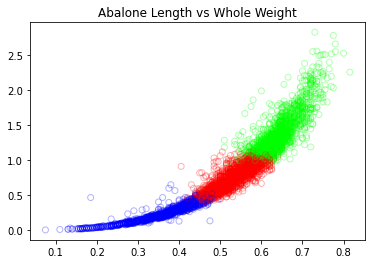

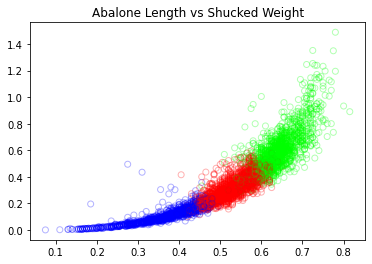

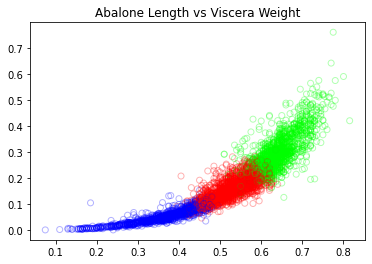

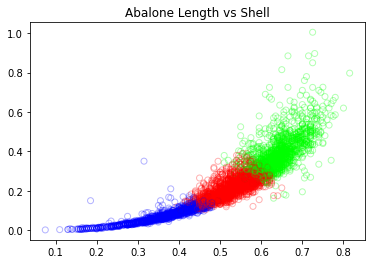

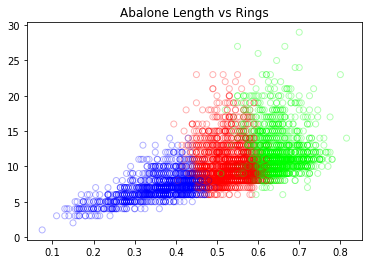

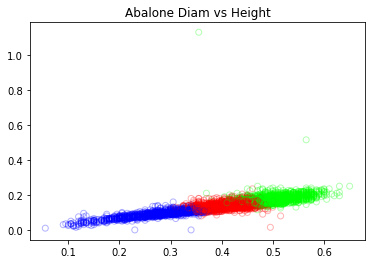

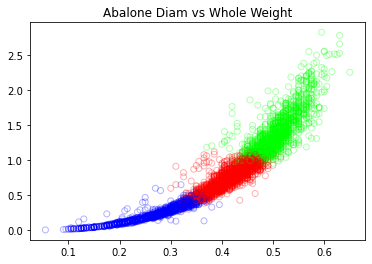

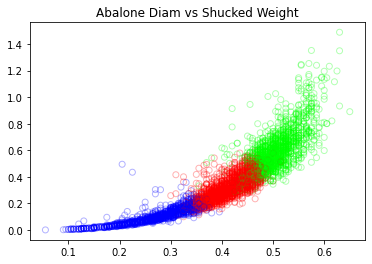

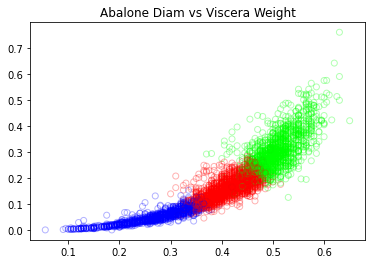

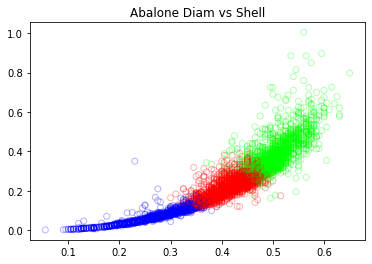

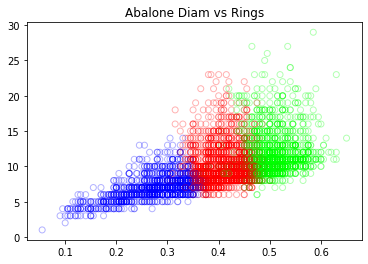

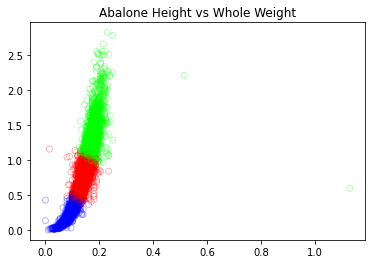

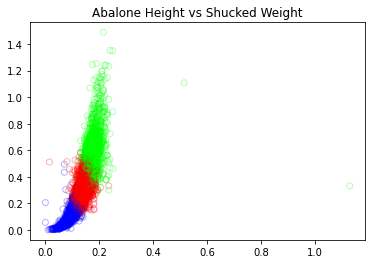

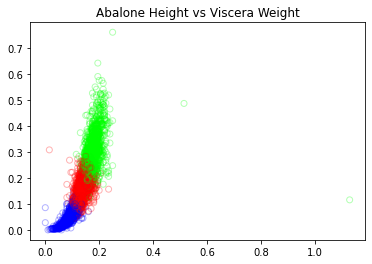

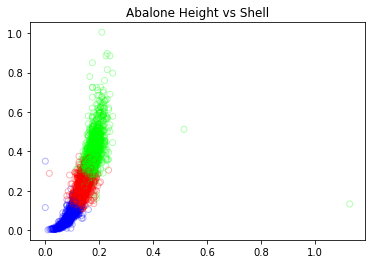

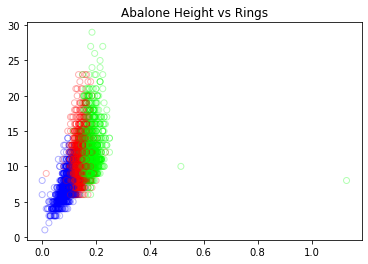

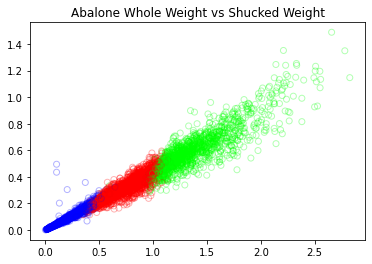

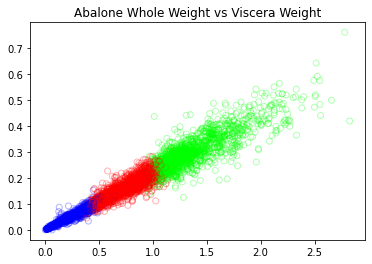

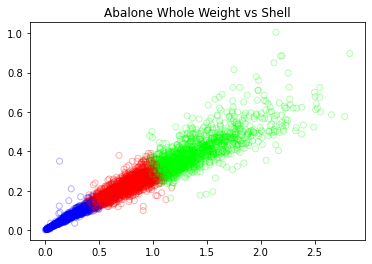

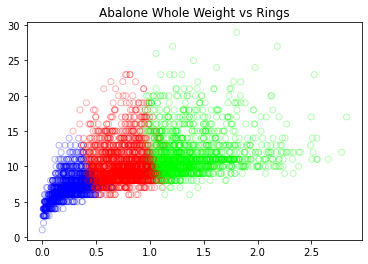

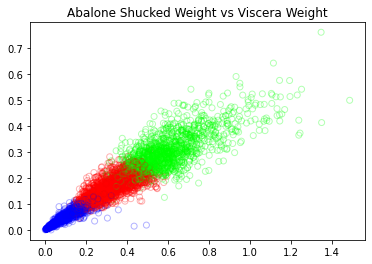

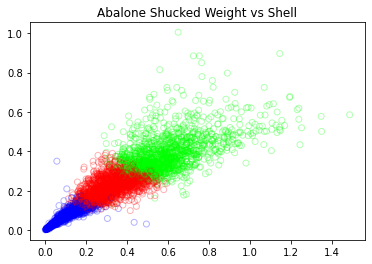

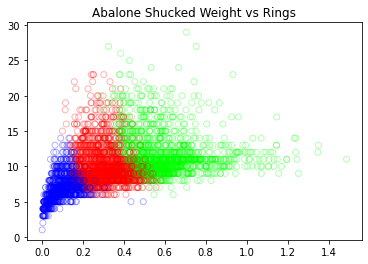

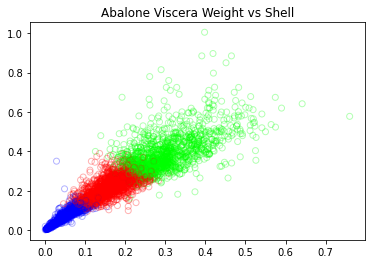

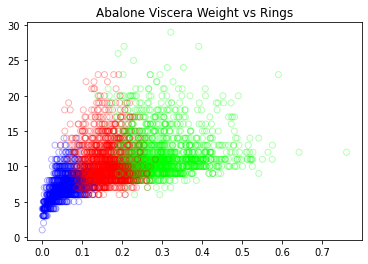

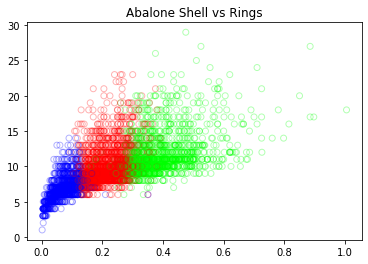

In [10]:
plot_result(v_best_predict_s)

In [11]:
# Select best ik
s_best_acc = 0
s_best_mfi = None
s_best_predict = None
s_best_predict_s = None
s_best_ik = 0
s_acc_list = []

for i in np.linspace(1, 11, 6):
    predict = spectral_clustering_mod(3, 'selftune', ik=i).fit(data_t)
    acc, mfi, predict_s = accuracy_calc(labels, predict, True)
    s_acc_list.append(acc)
    print(int(i), acc)
    if acc > s_best_acc:
        s_best_acc = acc
        s_best_mfi = mfi
        s_best_predict = predict
        s_best_predict_s = predict_s
        s_best_ik = i

print()
print('Best ik:', int(s_best_ik))
print('Total Accuracy:', s_best_acc)
print('Male Accuracy:', s_best_mfi[0])
print('Female Accuracy:', s_best_mfi[1])
print('Infant Accuracy:', s_best_mfi[2])

1 0.47593966961934403
3 0.4733062006224563
5 0.4651663873593488
7 0.4601388556380177
9 0.45678716782379697
11 0.4531960737371319

Best ik: 1
Total Accuracy: 0.47593966961934403
Male Accuracy: 0.7715968586387435
Female Accuracy: 0.0045906656465187455
Infant Accuracy: 0.5983606557377049


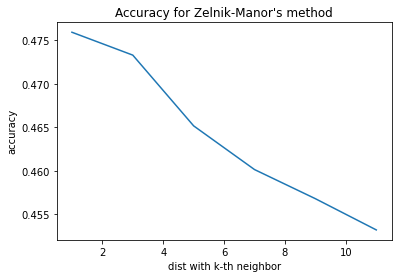

In [12]:
plt.title('Accuracy for Zelnik-Manor\'s method')
plt.xlabel('dist with k-th neighbor')
plt.ylabel('accuracy')
plt.plot(np.linspace(1, 11, 6), s_acc_list)
plt.show()

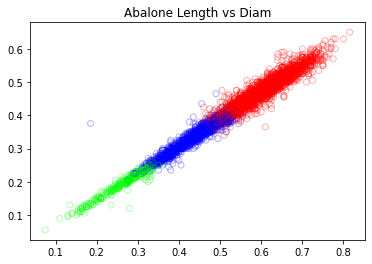

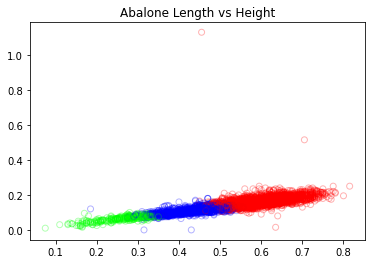

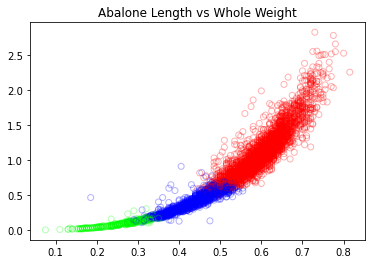

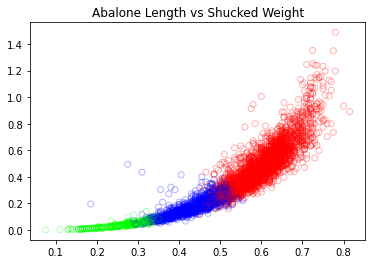

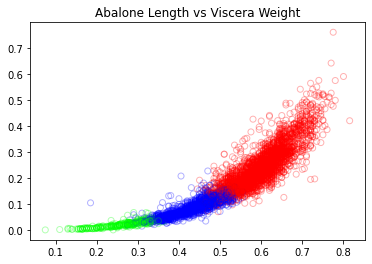

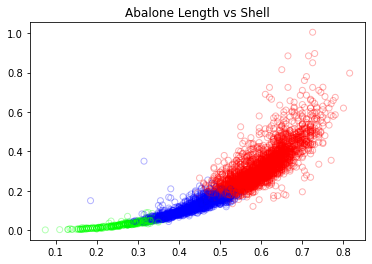

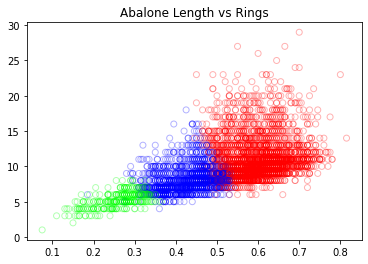

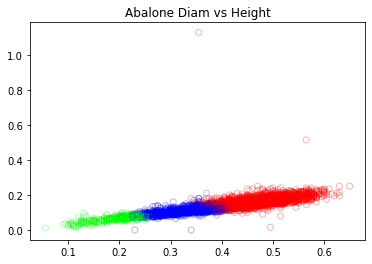

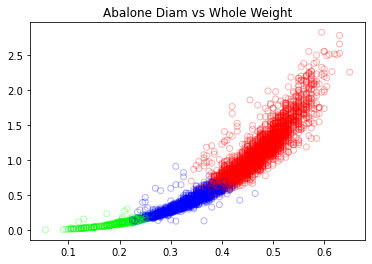

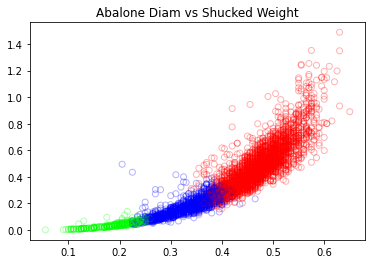

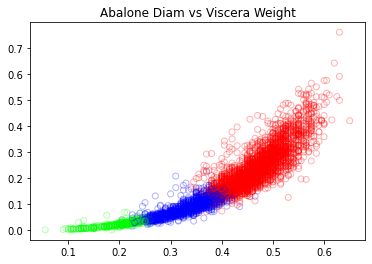

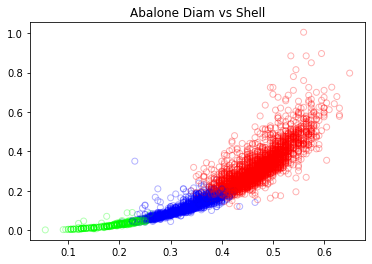

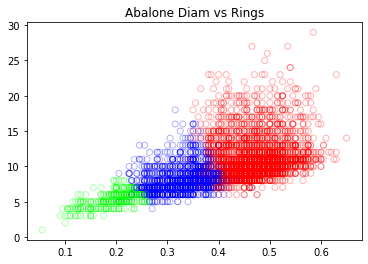

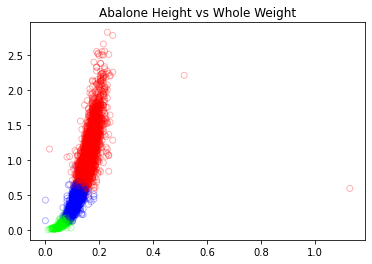

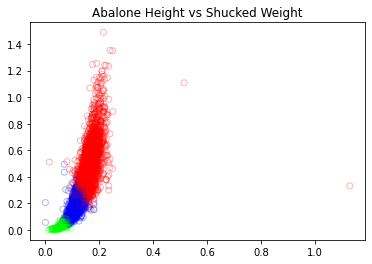

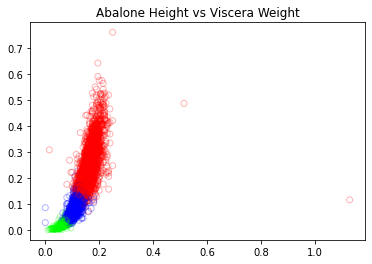

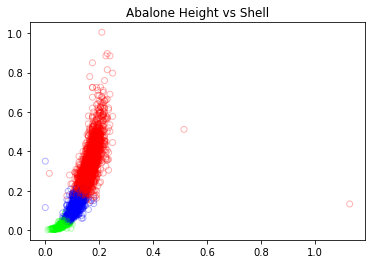

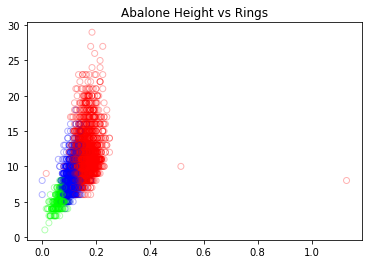

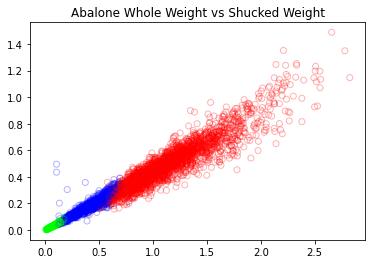

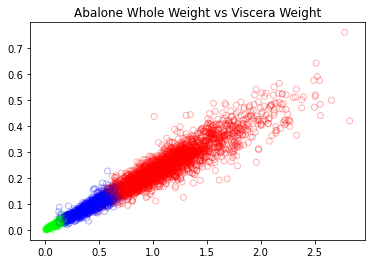

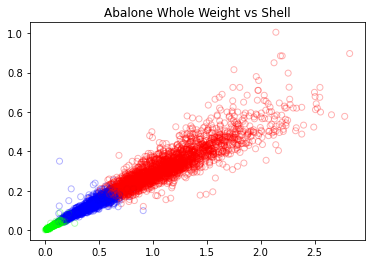

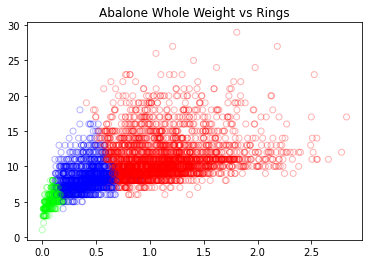

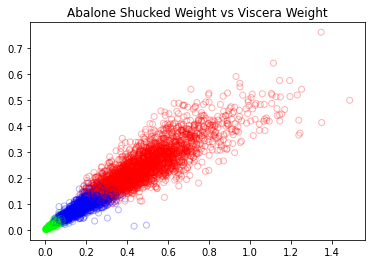

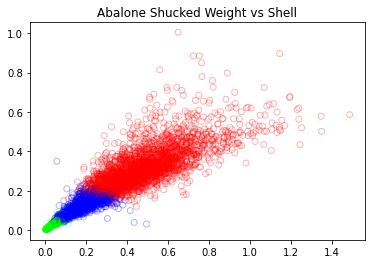

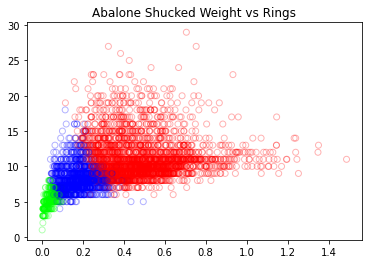

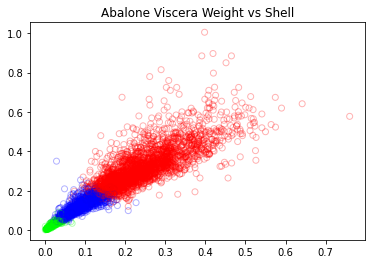

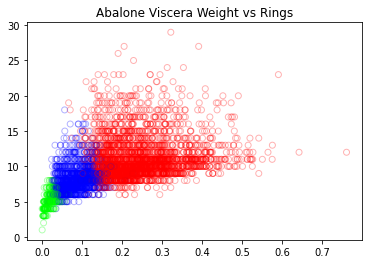

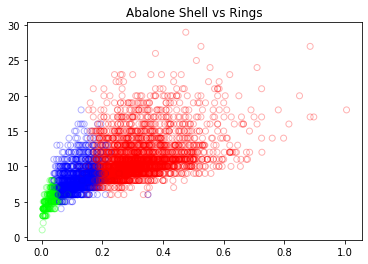

In [13]:
plot_result(s_best_predict_s)

In [14]:
# Select best ik for larger ik's
s_best_acc = 0
s_best_mfi = None
s_best_predict = None
s_best_predict_s = None
s_best_ik = 0
s_acc_list = []

for i in np.linspace(295, 305, 6):
    predict = spectral_clustering_mod(3, 'selftune', ik=i).fit(data_t)
    acc, mfi, predict_s = accuracy_calc(labels, predict, True)
    s_acc_list.append(acc)
    print(int(i), acc)
    if acc > s_best_acc:
        s_best_acc = acc
        s_best_mfi = mfi
        s_best_predict = predict
        s_best_predict_s = predict_s
        s_best_ik = i

print()
print('Best ik:', int(s_best_ik))
print('Total Accuracy:', s_best_acc)
print('Male Accuracy:', s_best_mfi[0])
print('Female Accuracy:', s_best_mfi[1])
print('Infant Accuracy:', s_best_mfi[2])

295 0.47737610725401003
297 0.47809432607134306
299 0.4788125448886761
301 0.47929135743356477
303 0.4790519511611204
305 0.4790519511611204

Best ik: 301
Total Accuracy: 0.47929135743356477
Male Accuracy: 0.3717277486910995
Female Accuracy: 0.6090283091048202
Infant Accuracy: 0.47540983606557374


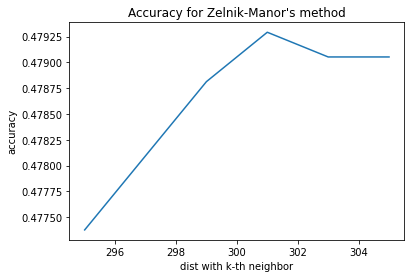

In [15]:
plt.title('Accuracy for Zelnik-Manor\'s method')
plt.xlabel('dist with k-th neighbor')
plt.ylabel('accuracy')
plt.plot(np.linspace(295, 305, 6), s_acc_list)
plt.show()

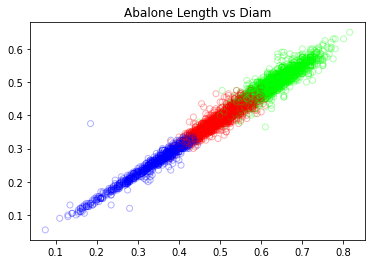

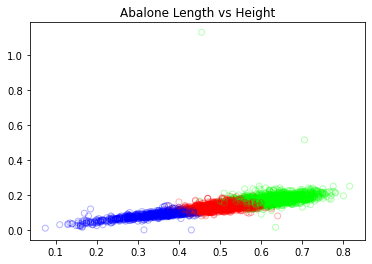

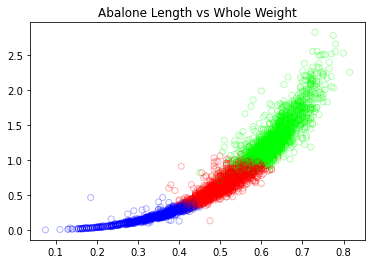

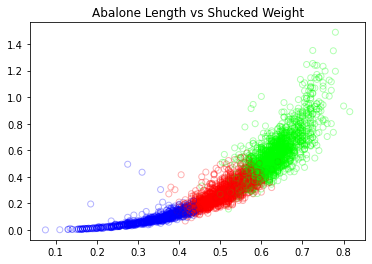

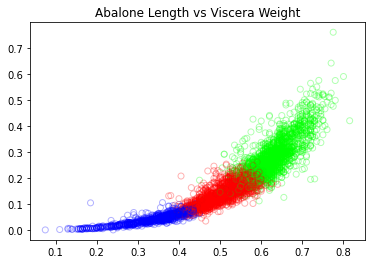

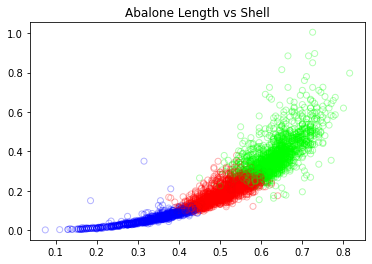

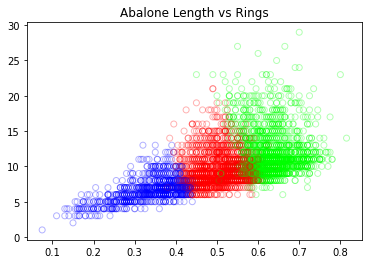

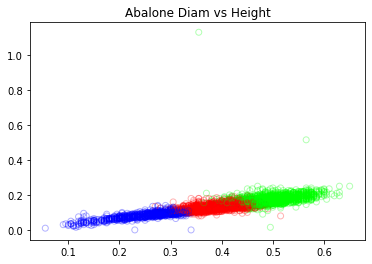

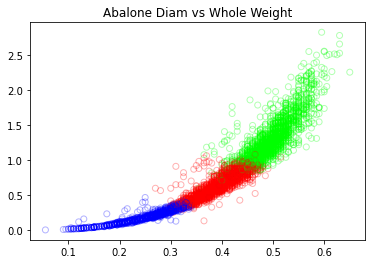

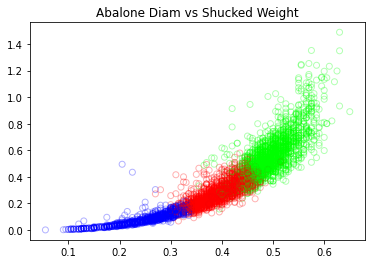

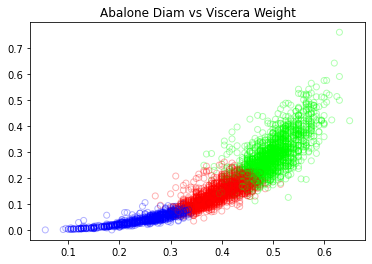

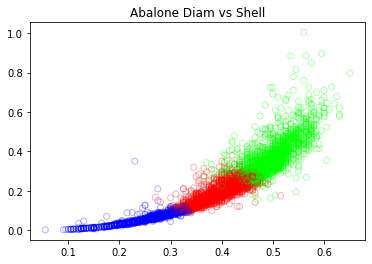

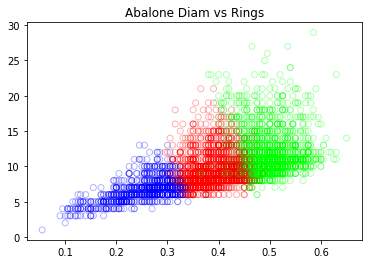

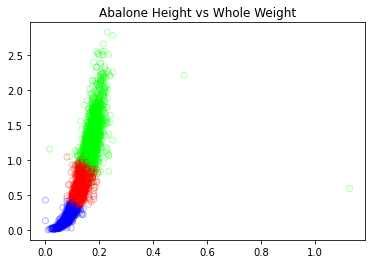

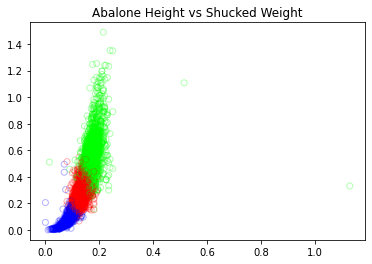

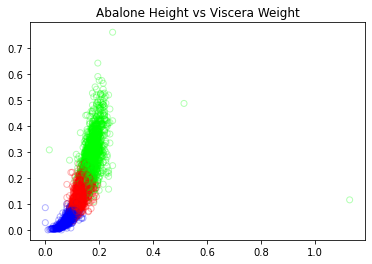

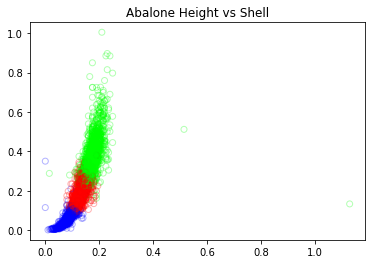

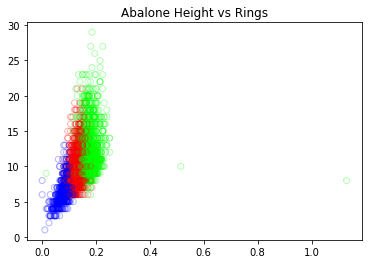

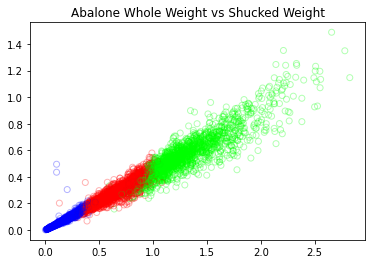

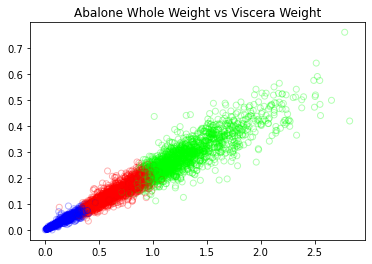

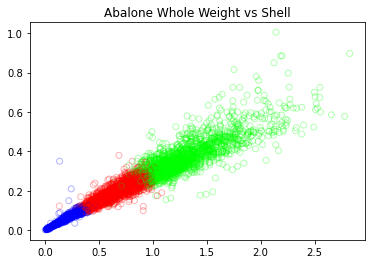

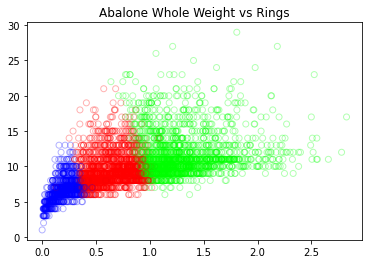

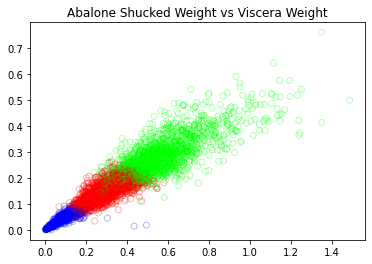

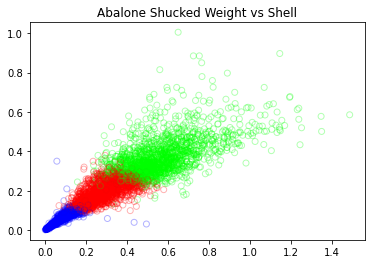

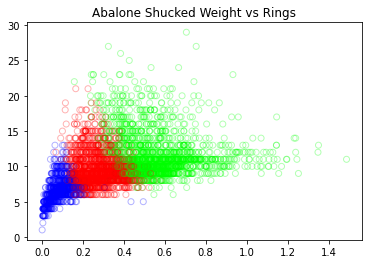

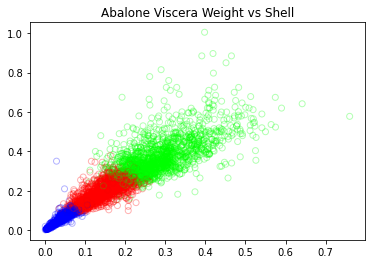

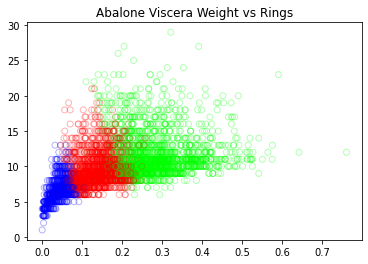

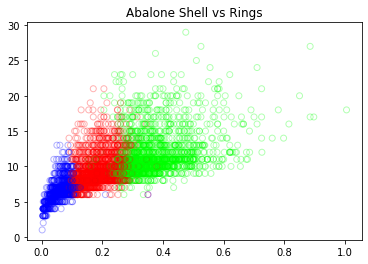

In [16]:
plot_result(s_best_predict_s)

## Reflection

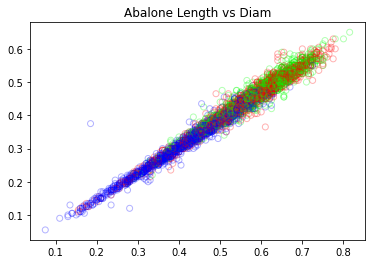

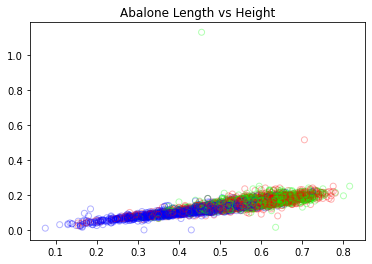

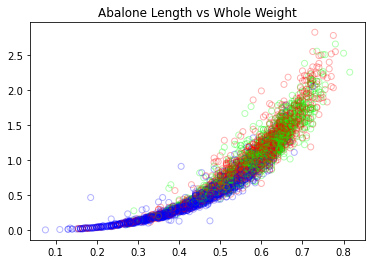

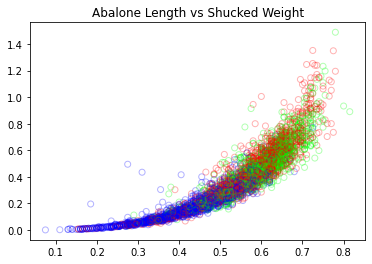

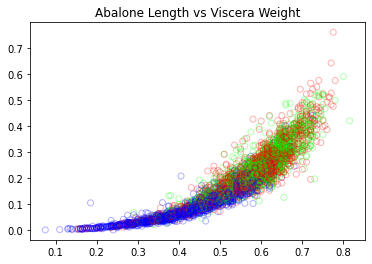

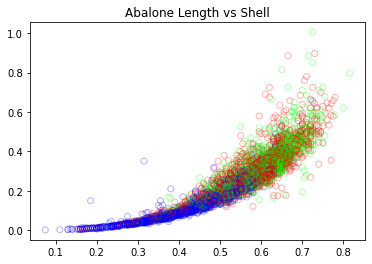

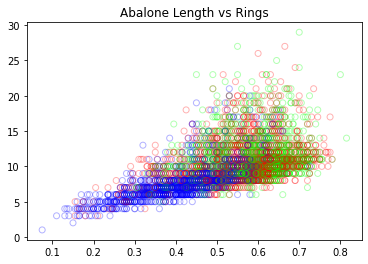

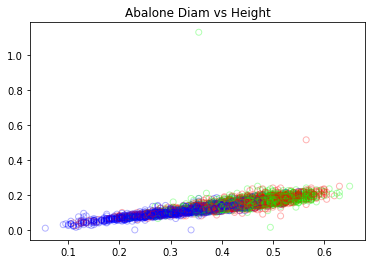

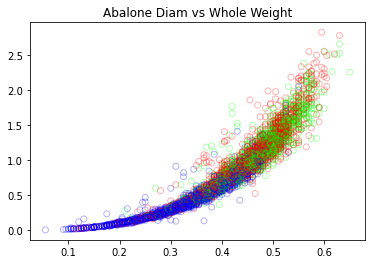

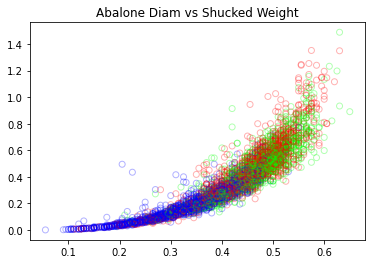

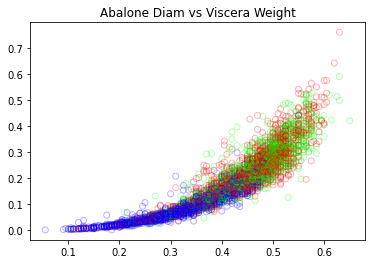

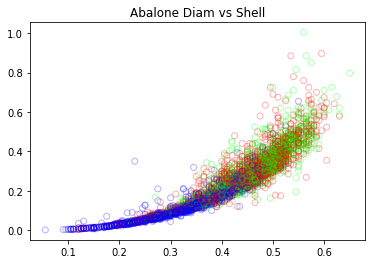

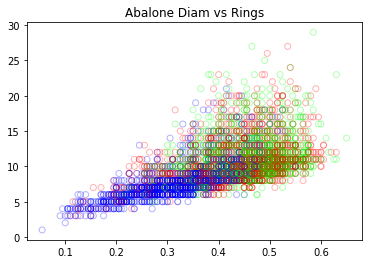

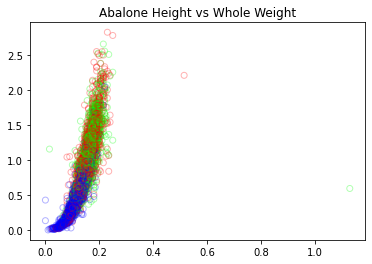

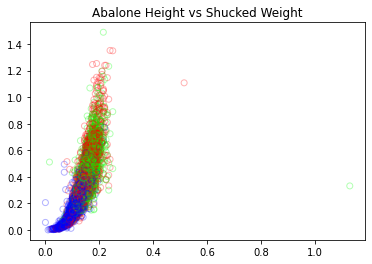

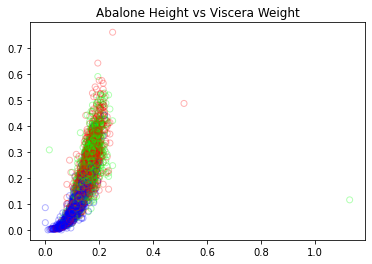

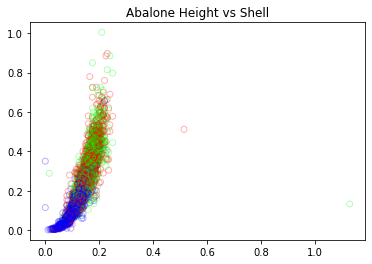

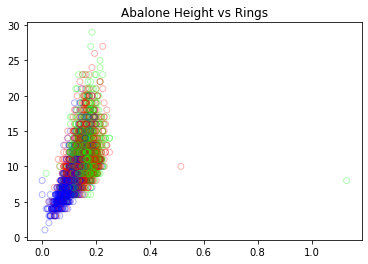

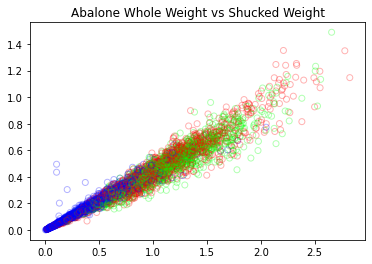

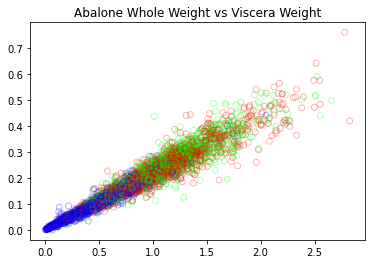

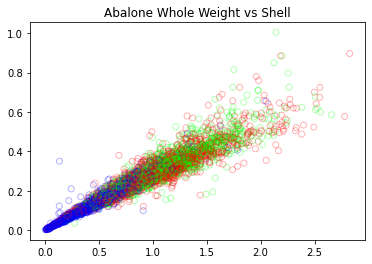

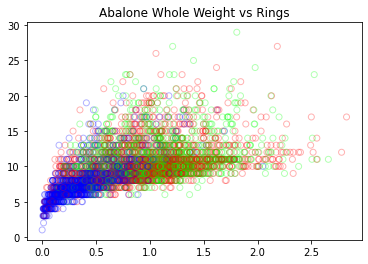

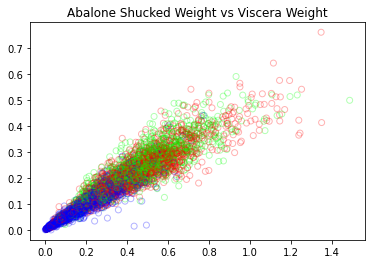

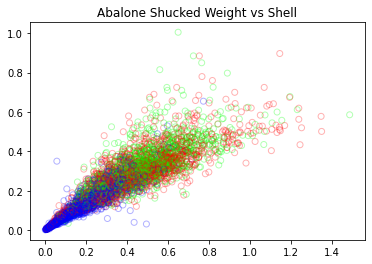

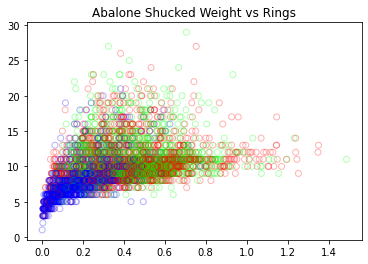

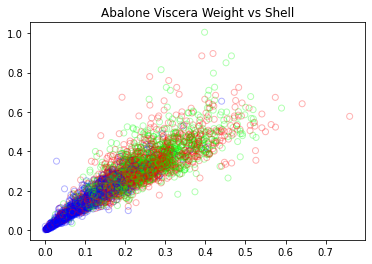

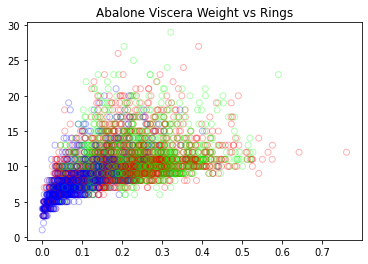

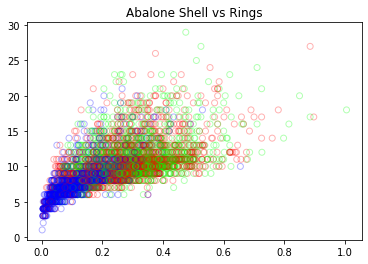

In [17]:
plot_result(labels)

Above are figures generated with real labels (sex). Red dots refer to males, green dots refer to females, and blue dots refer to infants.

For Ng's method, since the variance is fixed for all points and we can observe that red dots are usually mixed with the other two groups (mixed with green ones more), the accuracy of males prediction is lowest. Meanwhile, the blue dots are mixed least with other two groups, so the accuracy of infants is highest.

For Zelnik-Manor's method, for small k-th neighbor selected to calculate distance to get the scaling factors, local scaling does not work well. The accuracy for males is highest at the cost of almost completely incorrect assignment of females' groups. For larger k's, the grouping is better and more points are assigned to green group (females), so the accuracy of females is highest at the cost of accuracy of the other two groups with the permutation of labels with highest total accuracy.